In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# sense of derivative
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1 = ', d1)
print('d2 = ', d2)
print('slope = ', (d2 - d1)/h)

d1 =  4.0
d2 =  3.9999699999999994
slope =  -3.000000000064062


_______________________

In [62]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
        self.grad = 0.0
        self._backward = lambda: None
    
    def __repr__(self):
        return f'Value(data={self.data})'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')
    
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value((self.data * other.data), (self, other), '*')
    
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), 'only supporting int or float powers'
        out = Value((self.data ** other), (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward
        
        return out
            
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self ):
        return self*(-1)
    
    def __radd__(self, other):
        return self + other
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # utilizing topological sort
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
    

In [63]:
# run once per run
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [64]:
# visualizing the origin of a Value
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
        
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f }' % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name=uid+n._op , label=n._op)
            dot.edge(uid+n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

___________________________________________

In [65]:
# One simple neuron

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(2.0, label='x2')

# weights w1,w2
w1 = Value(-0.3, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(-1, label='b')

x1w1 = x1*w1
x1w1.label = 'x1*w1'
x2w2 = x2*w2
x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1 + x2w2'

n=x1w1x2w2 + b
n.label = 'n'

o = n.tanh()
o.label = 'o'

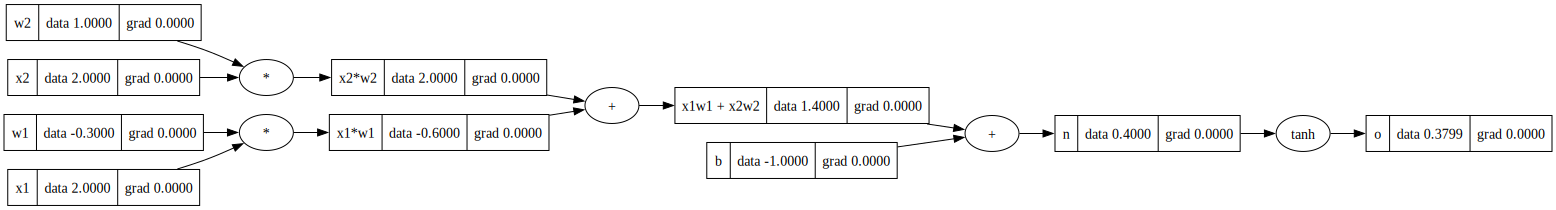

In [66]:
draw_dot(o)

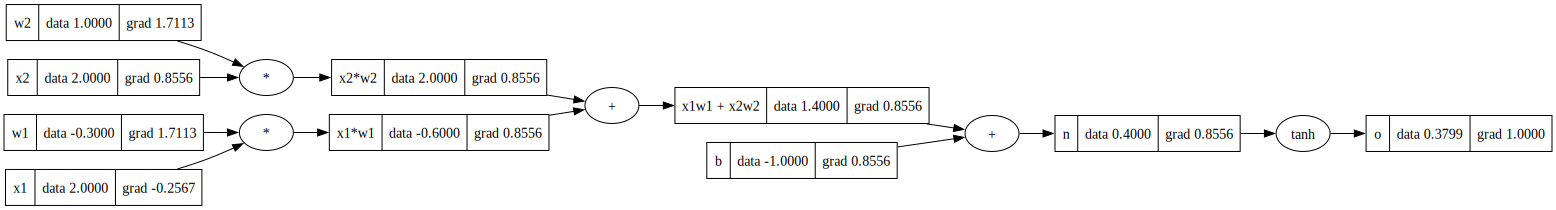

In [67]:
o.backward()
draw_dot(o)

In [68]:
# torch replicated
import torch

In [69]:
x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()   ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()   ; w2.requires_grad = True
b = torch.Tensor([6.88]).double()   ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print(x1.grad.item())
print(w1.grad.item())
print(x2.grad.item())
print(w2.grad.item())

0.7064193777288968
---
-1.5029149883073543
1.0019433255382362
0.5009716627691181
0.0


_____

In [142]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def parameters(self):
        return self.w + [self.b]
        
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out
    
    
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
    
class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [143]:
n = MLP(3, [4, 4, 1])

In [144]:
len(n.parameters())

41

In [145]:
# applying the backpropagation from micrograd

xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0] 
]
ys = [1.0, -1.0, -1.0, 1.0]

In [148]:
epochs = 200
lr = 0.01

# training loop
for k in range(epochs):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0  # zeroing the gradients
    loss.backward()
    
    # gradient descent
    for p in n.parameters():
        p.data += -lr * p.grad
    
    print(k, loss.data)

0 0.15732437354554837
1 0.15010987007125756
2 0.1434789531417526
3 0.13736665134699205
4 0.131716988453701
5 0.12648151789102094
6 0.12161812862548334
7 0.11709006664651286
8 0.11286512878814275
9 0.10891499509985905
10 0.10521467322489537
11 0.10174203381283622
12 0.09847742029951848
13 0.09540331973690777
14 0.09250408397626805
15 0.08976569256953826
16 0.08717555038429048
17 0.08472231422374916
18 0.08239574377877437
19 0.08018657306982492
20 0.07808639920710715
21 0.07608758583993545
22 0.07418317910786343
23 0.07236683426678416
24 0.07063275145891398
25 0.06897561933901428
26 0.06739056547032767
27 0.0658731125704795
28 0.0644191398263529
29 0.06302484861279324
30 0.061686732047015594
31 0.06040154789210163
32 0.059166294391667096
33 0.05797818867583028
34 0.0568346474278217
35 0.05573326954239253
36 0.05467182054281533
37 0.05364821855372172
38 0.05266052165309232
39 0.051706916449112156
40 0.050785707746868865
41 0.04989530918649371
42 0.04903423474871699
43 0.048201091036255445

In [149]:
ypred # type: ignore

[Value(data=0.9596009811642989),
 Value(data=-0.9350938300990951),
 Value(data=-0.9445133113006206),
 Value(data=0.9392607644049006)]